In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from scipy import stats

plt.style.use("tableau-colorblind10")

F_SHOW = False


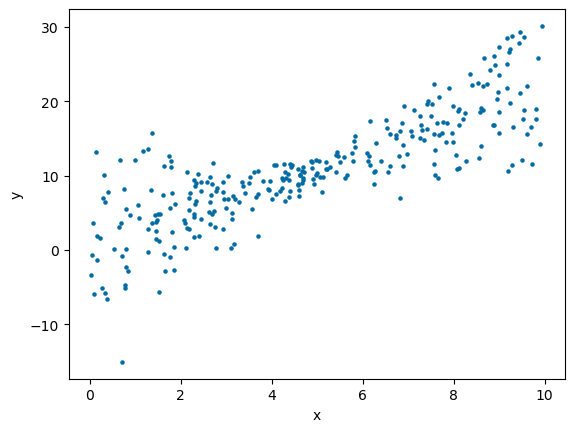

In [2]:
N = 300
rng = np.random.default_rng(123)

x = rng.uniform(0, 10, size=N)


def f(x):
    return 1 + 2*x

def g(x):
    return np.abs(x-5) + 1.0


eps = rng.normal(loc=0, scale=1.0, size=N)
y = f(x) + eps * g(x)

x_line = np.linspace(x.min(), x.max())
if F_SHOW:
    plt.plot(x_line, f(x_line), c="k", ls="--", label="f(x)")
    plt.legend()
plt.scatter(x, y, s=5)
plt.xlabel("x")
plt.ylabel("y")
plt.show()


In [3]:
df = pd.DataFrame.from_dict({"y": y, "x": x})
df.to_csv("toy_data_qr.csv", index=False)


# OLS

In [4]:
ols = sm.OLS(endog=y, exog=sm.add_constant(x)).fit()
ols.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     664.0
Date:                Thu, 08 Jun 2023   Prob (F-statistic):           8.09e-78
Time:                        22:11:52   Log-Likelihood:                -846.08
No. Observations:                 300   AIC:                             1696.
Df Residuals:                     298   BIC:                             1704.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6612      0.457      1.446      0.149      -0.239       1.561
x1             2.0956      0.081     25.769      0.000       1.936       2.256
==============================================================================
Omnibus:                        9.489   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               17.784
Skew:                           0.044   Prob(JB):                     0.000138
Kurtosis:                       4.190   Cond. No.                         11.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

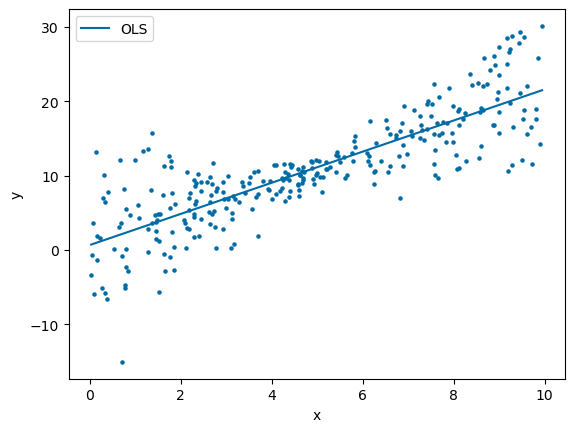

In [5]:
x_line = np.linspace(x.min(), x.max())

plt.scatter(x, y, s=5)
if F_SHOW:
    plt.plot(x_line, f(x_line), c="k", ls="--", label="f(x)")
plt.plot(x_line, ols.predict(sm.add_constant(x_line)), label="OLS")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()


# 分位点回帰

In [6]:
# 分位点(%)
qs = [2.5, 25, 50, 75, 97.5]

qr_models = dict()
for q in qs:
    qr_models[q] = sm.QuantReg(endog=y, exog=sm.add_constant(x)).fit(q=q / 100)


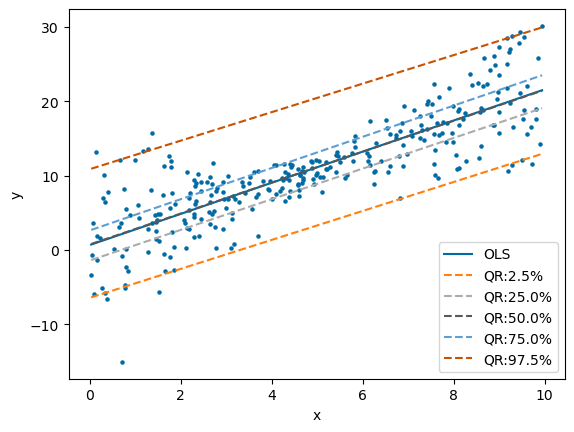

In [7]:
x_line = np.linspace(x.min(), x.max())

plt.scatter(x, y, s=5)
plt.plot(x_line, ols.predict(sm.add_constant(x_line)), label="OLS")

for q in qs:
    plt.plot(
        x_line,
        qr_models[q].predict(sm.add_constant(x_line)),
        ls="--",
        label="QR:{:.1f}%".format(q),
    )

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()


# 3次スプライン

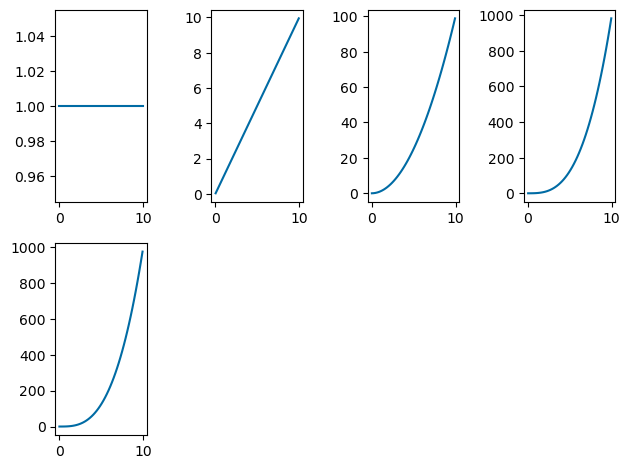

In [8]:
def PolyBasis(x, p=5):
    pwr = np.arange(p + 1)
    return x[:, None] ** pwr[None]

def CubicSplineBasis(x, n=3, xmin=x.min(), xmax=x.max()):
    knots = np.linspace(xmin, xmax, num=n - 1, endpoint=False)
    phi = PolyBasis(x, p=3)

    tps3 = x[:, None] - knots[None]
    tps3 = np.where(tps3 > 0, tps3, 0) ** 3

    phi = np.concatenate([phi, tps3], axis=1)
    return phi


x_line = np.linspace(x.min(), x.max())
phi_line = CubicSplineBasis(x_line, n=2)
for p in range(phi_line.shape[1]):
    plt.subplot(2, 4, p + 1)
    plt.plot(x_line, phi_line[:, p])
    # plt.legend()
plt.tight_layout()
plt.show()


In [9]:
phi = CubicSplineBasis(x, n=2)
nonlinear_ols = sm.OLS(endog=y, exog=phi).fit()
nonlinear_ols.summary()

# 分位点(%)
qs = [2.5, 25, 50, 75, 97.5]

nonlinear_qr_models = dict()
for q in qs:
    nonlinear_qr_models[q] = sm.QuantReg(endog=y, exog=sm.add_constant(phi)).fit(q=q / 100)


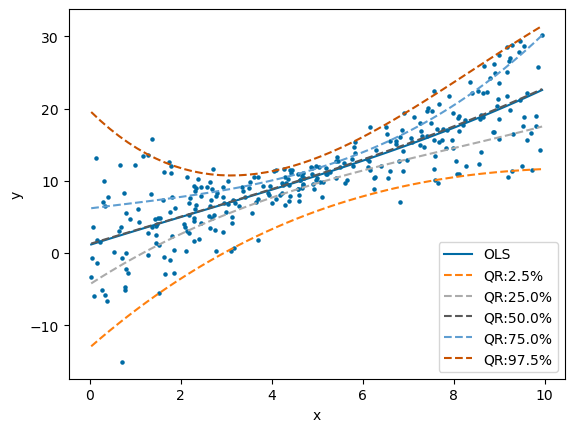

In [10]:
x_line = np.linspace(x.min(), x.max())
n = phi.shape[1] - 4 + 1
phi_line = CubicSplineBasis(x_line, n=n)


plt.scatter(x, y, s=5)
plt.plot(x_line, nonlinear_ols.predict(sm.add_constant(phi_line)), label="OLS")

for q in qs:
    plt.plot(
        x_line,
        nonlinear_qr_models[q].predict(sm.add_constant(phi_line)),
        ls="--",
        label="QR:{:.1f}%".format(q),
    )

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()
